In [35]:
import numpy as np
import datetime
from pathlib import Path

import matplotlib.pyplot as plt

from scipy.optimize import minimize

import astropy.units as u
from astropy.wcs import WCS
from astropy.time import Time
from astropy.table import Table, join, vstack, hstack
from astropy.io import fits
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astropy.coordinates import SkyCoord

from photutils import CircularAperture

from skycam_utils.astrometry import update_altaz, load_wcs
from skycam_utils.photometry import load_skycam_catalog, load_mask, match_stars
from skycam_utils.pipeline import process_stellacam_image, get_ut
from skycam_utils.fit_wcs import wcs_zea, wcs_refine_zea
from skycam_utils.fisheye_map import Fisheye, distortion_mapper, distortion_mapper_looper

In [2]:
mask = load_mask(year=2015)
wcs = load_wcs(year=2015)

In [46]:
fitsfile = "image_0003000.fits"
with fits.open(fitsfile) as hdul:
    im = hdul[0].data
    hdr = hdul[0].header
bkg_image, diff_image, segm, sky_mag, matched = process_stellacam_image(fitsfile, year=2015, write=True, zp=0)

In [47]:
dmag = matched['obs_mag'] - matched['Magnitude']
#matched = matched[dmag > -11]
dmag.mean(), dmag.std()

(-11.287639175388042, 0.8010965264319121)

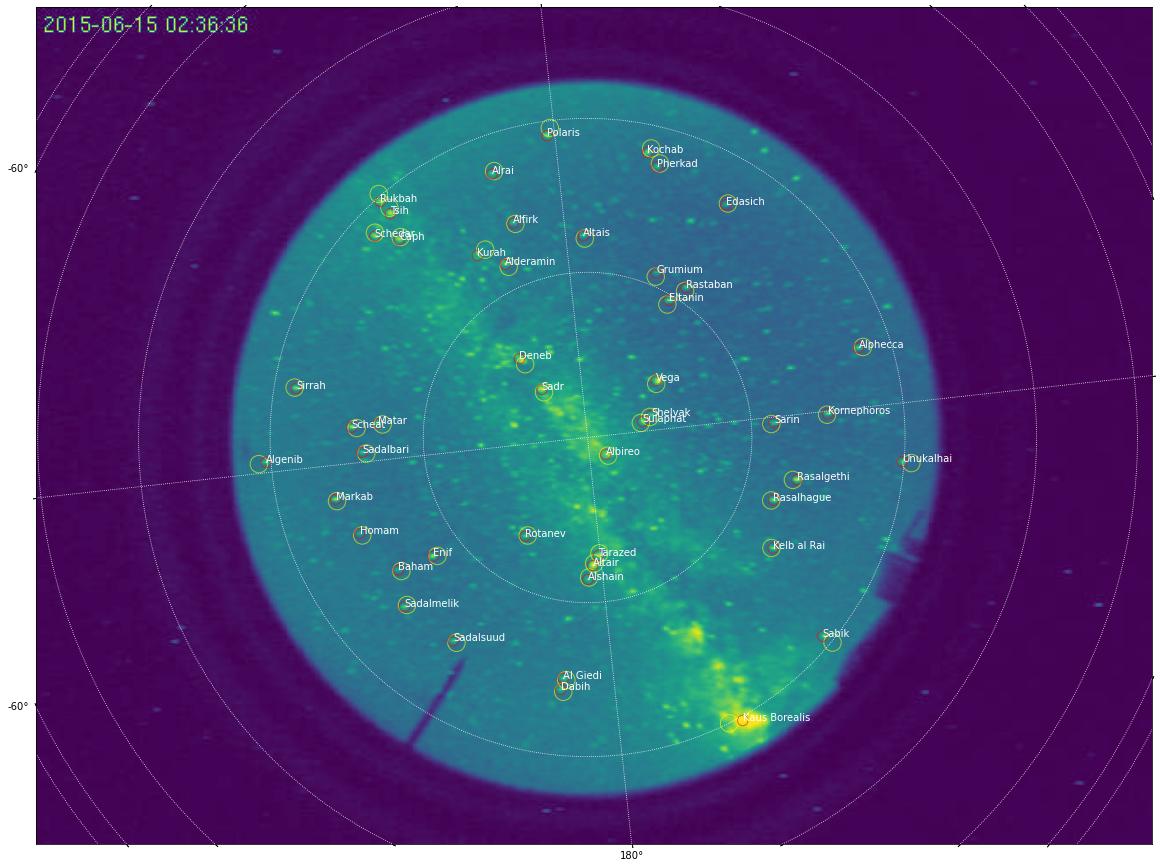

In [52]:
plt.figure(figsize=[20,20])
pred_x, pred_y = wcs.all_world2pix(matched['Az'], matched['Alt'], 0)
pred_aps = CircularAperture((pred_x, pred_y), r=5.)
meas_aps = CircularAperture((matched['xcentroid'], matched['ycentroid']), r=3.)
ax = plt.subplot(projection=wcs)
ax.imshow(im, origin='lower')
ax.coords[0].set_format_unit(u.deg)
ax.coords[0].set_auto_axislabel(False)
ax.coords[1].set_auto_axislabel(False)
ax.grid(color='white', ls='dotted')
pred_aps.plot(color='yellow', lw=1., alpha=0.6)
meas_aps.plot(color='red', lw=1, alpha=0.6)
for row in matched:
    ax.annotate(row['Star Name'], (row['xcentroid'].value, row['ycentroid'].value), color='white')
plt.show()

In [39]:
pwd = Path(".")
cats = []
for f in pwd.glob("*cat.csv"):
    cats.append(Table.read(f))

In [43]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA-SIP'  'DEC--ZEA-SIP'  
CRVAL : 0.0  90.0  
CRPIX : 316.98590819865  233.50973516466  
PC1_1 PC1_2  : 0.34493620567715  0.037452424101192  
PC2_1 PC2_2  : -0.035366571635143  0.32212297620874  
CDELT : 0.90698650633966  0.96624834520276  
NAXIS : 0  0

In [49]:
allcat = vstack(cats)
fun = wcs_zea(allcat['xcentroid'], allcat['ycentroid'], allcat['Alt'], allcat['Az'], crpix1=317, crpix2=233, a_order=2, b_order=2)
init = np.array([324, 235, 1, 1, 0.34, 0.03, 0.03, 0.33])
sip_init = np.zeros(18)
x0 = np.append(init, sip_init)
#x0 = init
fit_result = minimize(fun, x0)
wcs_refined = fun.return_wcs(fit_result.x)

In [50]:
wcs_refined

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA-SIP'  'DEC--ZEA-SIP'  
CRVAL : 0.0  90.0  
CRPIX : 335.7722102287557  219.05878069878432  
PC1_1 PC1_2  : 0.3028645300018989  0.06712499122518423  
PC2_1 PC2_2  : -0.04014944622017309  0.29263180267331346  
CDELT : 1.0296443916391305  1.1823356441008022  
NAXIS : 0  0

In [54]:
hdr['FRAME'] == '256 Frames'

True